**Estructura del Modelo**

In [63]:
import numpy as np
from numpy.linalg import det, inv

In [64]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [65]:
    class BaseBayesianClassifier:
      def __init__(self):
        self.encoder = ClassEncoder()

      def _estimate_a_priori(self, y):
        a_priori = np.bincount(y.flatten().astype(int)) / y.size
        # Q3: para que sirve bincount?
        return np.log(a_priori)

      def _fit_params(self, X, y):
        # estimate all needed parameters for given model
        raise NotImplementedError()

      def _predict_log_conditional(self, x, class_idx):
        # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
        # this should depend on the model used
        raise NotImplementedError()

      def fit(self, X, y, a_priori=None):
        # first encode the classes
        y = self.encoder.fit_transform(y)

        # if it's needed, estimate a priori probabilities
        self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

        # check that a_priori has the correct number of classes
        assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

        # now that everything else is in place, estimate all needed parameters for given model
        self._fit_params(X, y)
        # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

      def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

        for i in range(m_obs):
          encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
          y_hat[i] = self.encoder.names[encoded_y_hat_i]

        # return prediction as a row vector (matching y)
        return y_hat.reshape(1,-1)

      def _predict_one(self, x):
        # calculate all log posteriori probabilities (actually, +C)
        log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                      in enumerate(self.log_a_priori) ]

        # return the class that has maximum a posteriori probability
        return np.argmax(log_posteriori)

In [66]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [67]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

**Código de prueba**


In [68]:
# hiperparámetros
rng_seed = 6543

In [69]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full


def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [70]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [71]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

In [72]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()



train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
print(f"Train X: {train_x.shape}, Train Y: {train_y.shape}")
print(f"Test X: {test_x.shape}, Test Y: {test_y.shape}")

(4, 90) (1, 90) (4, 60) (1, 60)
Train X: (4, 90), Train Y: (1, 90)
Test X: (4, 60), Test Y: (1, 60)


In [73]:
# Inicializar el modelo QDA
qda = QDA()

# Entrenamiento con priors por defecto (estimados a partir de los datos)
qda.fit(train_x, train_y)
train_acc_default = accuracy(train_y, qda.predict(train_x))
test_acc_default = accuracy(test_y, qda.predict(test_x))
print(f"Priors por defecto - Error de entrenamiento: {1 - train_acc_default:.4f}, Error de prueba: {1 - test_acc_default:.4f}")

# Definir priors uniformes
priors_uniform = np.array([1/3, 1/3, 1/3])

# Entrenamiento con priors uniformes
qda_uniform = QDA()
qda_uniform.fit(train_x, train_y, a_priori=priors_uniform)
train_acc_uniform = accuracy(train_y, qda_uniform.predict(train_x))
test_acc_uniform = accuracy(test_y, qda_uniform.predict(test_x))
print(f"Priors Uniformes - Error de entrenamiento: {1 - train_acc_uniform:.4f}, Error de prueba: {1 - test_acc_uniform:.4f}")

# Definir priors asimétricos
# Asignar 0.9 a cada clase en una iteración
priors_asimetric = [
    np.array([0.9, 0.05, 0.05]),
    np.array([0.05, 0.9, 0.05]),
    np.array([0.05, 0.05, 0.9])
]

# Entrenamiento con priors asimétricos
for idx, prior in enumerate(priors_asimetric):
    qda_asym = QDA()
    qda_asym.fit(train_x, train_y, a_priori=prior)
    train_acc_asym = accuracy(train_y, qda_asym.predict(train_x))
    test_acc_asym = accuracy(test_y, qda_asym.predict(test_x))
    print(f"Priors Asimétricos {idx+1} (Clase {idx+1} con 0.9) - Error de entrenamiento: {1 - train_acc_asym:.4f}, Error de prueba: {1 - test_acc_asym:.4f}")


Priors por defecto - Error de entrenamiento: 0.0111, Error de prueba: 0.0167
Priors Uniformes - Error de entrenamiento: 0.0222, Error de prueba: 0.0167
Priors Asimétricos 1 (Clase 1 con 0.9) - Error de entrenamiento: 0.0222, Error de prueba: 0.0167
Priors Asimétricos 2 (Clase 2 con 0.9) - Error de entrenamiento: 0.0333, Error de prueba: 0.0000
Priors Asimétricos 3 (Clase 3 con 0.9) - Error de entrenamiento: 0.0333, Error de prueba: 0.0500


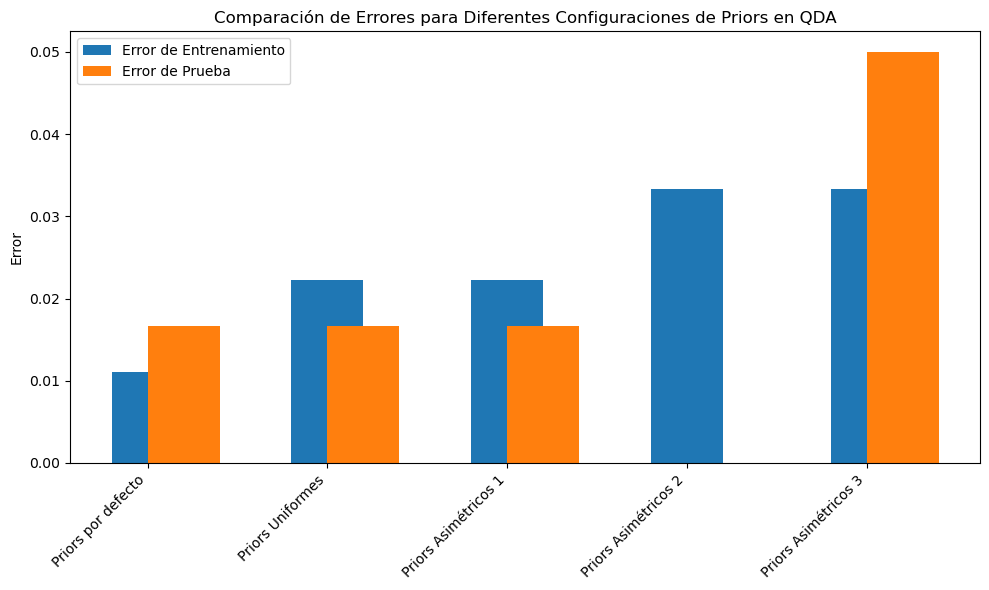

In [74]:
import matplotlib.pyplot as plt

# Datos de errores
configuraciones = [
    'Priors por defecto',
    'Priors Uniformes',
    'Priors Asimétricos 1',
    'Priors Asimétricos 2',
    'Priors Asimétricos 3'
]

error_entrenamiento = [0.0111, 0.0222, 0.0222, 0.0333, 0.0333]
error_prueba = [0.0167, 0.0167, 0.0167, 0.0000, 0.0500]

x = range(len(configuraciones))

plt.figure(figsize=(10,6))
plt.bar(x, error_entrenamiento, width=0.4, label='Error de Entrenamiento', align='center')
plt.bar(x, error_prueba, width=0.4, label='Error de Prueba', align='edge')
plt.xticks(x, configuraciones, rotation=45, ha='right')
plt.ylabel('Error')
plt.title('Comparación de Errores para Diferentes Configuraciones de Priors en QDA')
plt.legend()
plt.tight_layout()
plt.show()


# Punto 2

## Data set Pinguins

In [75]:
# Cargar los datos
X_full_p, y_full_p = get_penguins()
print(f"Penguins X: {X_full_p.shape}, Penguins Y: {y_full_p.shape}")

# Dividir los datos en entrenamiento y prueba (70-30)
rng_seed = 6543
train_x_p, train_y_p, test_x_p, test_y_p = split_transpose(X_full_p, y_full_p, test_sz=0.3, random_state=rng_seed)
print(f"Train X: {train_x_p.shape}, Train Y: {train_y_p.shape}")
print(f"Test X: {test_x_p.shape}, Test Y: {test_y_p.shape}")


Penguins X: (342, 4), Penguins Y: (342, 1)
Train X: (4, 205), Train Y: (1, 205)
Test X: (4, 137), Test Y: (1, 137)


###  Entrenamiento con priors por defecto (estimados a partir de los datos)

In [76]:
# Inicializar el modelo QDA
qda_p = QDA()

# Entrenamiento con priors por defecto (estimados a partir de los datos)
qda_p.fit(train_x_p, train_y_p)
train_acc_p_default = accuracy(train_y_p, qda_p.predict(train_x_p))
test_acc_p_default = accuracy(test_y_p, qda_p.predict(test_x_p))
print(f"Priors por defecto - Error de entrenamiento: {1 - train_acc_p_default:.4f}, Error de prueba: {1 - test_acc_p_default:.4f}")

Priors por defecto - Error de entrenamiento: 0.0146, Error de prueba: 0.0146


### Definir priors uniformes en función de la cantidad de clases que contiene el dataset


In [77]:
# Definir priors uniformes
unique_classes_p, counts_p = np.unique(y_full_p, return_counts=True)
num_classes_p = len(unique_classes_p)
priors_uniform_p = np.array([1/num_classes_p] * num_classes_p)
print("\nDistribución a priori Uniforme:", priors_uniform_p)


Distribución a priori Uniforme: [0.33333333 0.33333333 0.33333333]


### Entrenamiento con priors uniformes

In [78]:
qda_p_uniform = QDA()
qda_p_uniform.fit(train_x_p, train_y_p, a_priori=priors_uniform_p)
train_acc_p_uniform = accuracy(train_y_p, qda_p_uniform.predict(train_x_p))
test_acc_p_uniform = accuracy(test_y_p, qda_p_uniform.predict(test_x_p))
print(f"Priors Uniformes - Error de entrenamiento: {1 - train_acc_p_uniform:.4f}, Error de prueba: {1 - test_acc_p_uniform:.4f}")

Priors Uniformes - Error de entrenamiento: 0.0098, Error de prueba: 0.0073


### Definir priors asimétricos (una clase con 0.9 y las demás con 0.05)

In [79]:
priors_asimetric_p = []
for i in range(num_classes_p):
    prior = np.array([0.05] * num_classes_p)
    prior[i] = 0.9
    prior /= prior.sum()  # Asegurar que sumen 1
    priors_asimetric_p.append(prior)
print (priors_asimetric_p)

[array([0.9 , 0.05, 0.05]), array([0.05, 0.9 , 0.05]), array([0.05, 0.05, 0.9 ])]


### Entrenamiento con priors asimétricos

In [80]:
for idx, prior in enumerate(priors_asimetric_p):
    class_name = unique_classes_p[idx][0] if isinstance(unique_classes_p[idx], np.ndarray) else unique_classes_p[idx]
    qda_p_asym = QDA()
    qda_p_asym.fit(train_x_p, train_y_p, a_priori=prior)
    train_acc_asym = accuracy(train_y_p, qda_p_asym.predict(train_x_p))
    test_acc_asym = accuracy(test_y_p, qda_p_asym.predict(test_x_p))
    print(f"Priors Asimétricos {idx+1} (Clase {class_name} con 0.9) - Error de entrenamiento: {1 - train_acc_asym:.4f}, Error de prueba: {1 - test_acc_asym:.4f}")

Priors Asimétricos 1 (Clase Adelie con 0.9) - Error de entrenamiento: 0.0195, Error de prueba: 0.0219
Priors Asimétricos 2 (Clase Chinstrap con 0.9) - Error de entrenamiento: 0.0098, Error de prueba: 0.0219
Priors Asimétricos 3 (Clase Gentoo con 0.9) - Error de entrenamiento: 0.0098, Error de prueba: 0.0073


# Punto 3

### Implementación de la Clase LDA

In [81]:
import numpy as np
from numpy.linalg import inv, det

class LDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        num_classes = len(self.log_a_priori)
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True) for idx in range(num_classes)]
        
        # Calcular la matriz de covarianza compartida
        # Inicializar con ceros
        covariance_shared = np.zeros((X.shape[0], X.shape[0]))
        for idx in range(num_classes):
            X_k = X[:, y.flatten() == idx]
            mean_k = self.means[idx]
            # Calcular la matriz de covarianza para la clase k
            # bias=True para calcular la covarianza con N (no N-1)
            covariance_k = np.cov(X_k, bias=True)
            covariance_shared += covariance_k * X_k.shape[1]
        
        # Dividir por el total de muestras para obtener la covarianza compartida
        self.covariance_shared = covariance_shared / X.shape[1]
        self.inv_covariance_shared = inv(self.covariance_shared)
        self.det_covariance_shared = det(self.covariance_shared)
    
    def _predict_log_conditional(self, x, class_idx):
        # Calcular el discriminante lineal para la clase k
        mean_k = self.means[class_idx]
        inv_cov = self.inv_covariance_shared
        
        # Discriminante lineal: x^T Σ^{-1} μ_k - 0.5 μ_k^T Σ^{-1} μ_k
        discriminant = x.T @ inv_cov @ mean_k - 0.5 * mean_k.T @ inv_cov @ mean_k
        return discriminant


In [82]:
# Inicializar el modelo LDA
lda = LDA()

# Entrenamiento con priors por defecto (estimados a partir de los datos)
lda.fit(train_x, train_y)
train_acc_default = accuracy(train_y, lda.predict(train_x))
test_acc_default = accuracy(test_y, lda.predict(test_x))
print(f"LDA Priors por defecto - Error de entrenamiento: {1 - train_acc_default:.4f}, Error de prueba: {1 - test_acc_default:.4f}")

LDA Priors por defecto - Error de entrenamiento: 0.0222, Error de prueba: 0.0167


# Parte 3

#### Se define la clase LDA 

In [83]:
class LDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        # Calcular la media de cada clase
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True) for idx in range(len(self.log_a_priori))]

        # Calcular la matriz de covarianza compartida
        # En LDA, se asume que todas las clases comparten la misma matriz de covarianza
        # Calculamos una matriz de covarianza promedio ponderada por el número de instancias de cada clase
        self.cov_shared = np.zeros((X.shape[0], X.shape[0]))
        total_instances = 0
        for idx in range(len(self.log_a_priori)):
            X_k = X[:, y.flatten() == idx]
            total_instances += X_k.shape[1]
            self.cov_shared += (X_k - self.means[idx]) @ (X_k - self.means[idx]).T

        self.cov_shared /= total_instances

        # Invertir la matriz de covarianza compartida
        self.inv_cov_shared = inv(self.cov_shared)

    def _predict_log_conditional(self, x, class_idx):
        # En LDA, P(x|G=k) es una distribución normal con media mu_k y covarianza compartida
        # El logaritmo de P(x|G=k) es:
        # log P(x|G=k) = -0.5 * (x - mu_k)^T * inv_cov_shared * (x - mu_k) - 0.5 * log(det(cov_shared)) - (d/2)*log(2*pi)
        # Para propósitos de comparación, podemos omitir términos que son constantes para todas las clases
        # Por lo tanto, podemos usar:
        # log P(x|G=k) = -0.5 * (x - mu_k)^T * inv_cov_shared * (x - mu_k) + c
        # Donde 'c' es una constante que no afecta la argmax

        diff = x - self.means[class_idx]
        return -0.5 * (diff.T @ self.inv_cov_shared @ diff)[0,0] + 0  # 'c' omitido

### Se utiliza el data set de Iris

In [84]:
print(f"X: {X_full.shape}, Y: {y_full.shape}")
print(f"Train X: {train_x.shape}, Train Y: {train_y.shape}")
print(f"Test X: {test_x.shape}, Test Y: {test_y.shape}")


X: (150, 4), Y: (150, 1)
Train X: (4, 90), Train Y: (1, 90)
Test X: (4, 60), Test Y: (1, 60)


### Inicializar el modelo LDA

In [85]:
lda = LDA()



### Entrenamiento con priors por defecto (estimados a partir de los datos)

In [86]:

lda.fit(train_x, train_y)
train_acc_default = accuracy(train_y, lda.predict(train_x))
test_acc_default = accuracy(test_y, lda.predict(test_x))
print(f"Priors por defecto - Error de entrenamiento: {1 - train_acc_default:.4f}, Error de prueba: {1 - test_acc_default:.4f}")

Priors por defecto - Error de entrenamiento: 0.0222, Error de prueba: 0.0167


### Definir priors uniformes

In [87]:
unique_classes, counts = np.unique(y_full, return_counts=True)
num_classes = len(unique_classes)
priors_uniform = np.array([1/num_classes] * num_classes)
print("\nDistribución a priori Uniforme:", priors_uniform)


Distribución a priori Uniforme: [0.33333333 0.33333333 0.33333333]


### Entrenamiento con priors uniformes

In [88]:

lda_uniform = LDA()
lda_uniform.fit(train_x, train_y, a_priori=priors_uniform)
train_acc_uniform = accuracy(train_y, lda_uniform.predict(train_x))
test_acc_uniform = accuracy(test_y, lda_uniform.predict(test_x))
print(f"Priors Uniformes - Error de entrenamiento: {1 - train_acc_uniform:.4f}, Error de prueba: {1 - test_acc_uniform:.4f}")

Priors Uniformes - Error de entrenamiento: 0.0222, Error de prueba: 0.0167


# Data Set Pinguins

In [89]:
print(f"Train X: {train_x_p.shape}, Train Y: {train_y_p.shape}")
print(f"Test X: {test_x_p.shape}, Test Y: {test_y_p.shape}")

Train X: (4, 205), Train Y: (1, 205)
Test X: (4, 137), Test Y: (1, 137)


### Inicializar el modelo LDA

In [90]:

lda_p = LDA()

### Entrenamiento con priors por defecto (estimados a partir de los datos)

In [91]:
lda_p.fit(train_x_p, train_y_p)
train_acc_p_default = accuracy(train_y_p, lda_p.predict(train_x_p))
test_acc_p_default = accuracy(test_y_p, lda_p.predict(test_x_p))
print(f"Priors por defecto - Error de entrenamiento: {1 - train_acc_p_default:.4f}, Error de prueba: {1 - test_acc_p_default:.4f}")


Priors por defecto - Error de entrenamiento: 0.0098, Error de prueba: 0.0146


### Definir priors uniformes

In [92]:
unique_classes_p, counts_p = np.unique(y_full_p, return_counts=True)
num_classes_p = len(unique_classes_p)
priors_uniform_p = np.array([1/num_classes_p] * num_classes_p)
print("\nDistribución a priori Uniforme:", priors_uniform_p)


Distribución a priori Uniforme: [0.33333333 0.33333333 0.33333333]


### Entrenamiento con priors uniformes

In [93]:
lda_p_uniform = LDA()
lda_p_uniform.fit(train_x_p, train_y_p, a_priori=priors_uniform_p)
train_acc_p_uniform = accuracy(train_y_p, lda_p_uniform.predict(train_x_p))
test_acc_p_uniform = accuracy(test_y_p, lda_p_uniform.predict(test_x_p))
print(f"Priors Uniformes - Error de entrenamiento: {1 - train_acc_p_uniform:.4f}, Error de prueba: {1 - test_acc_p_uniform:.4f}")

Priors Uniformes - Error de entrenamiento: 0.0098, Error de prueba: 0.0073


# Parte 5

### Entrenar Ambos Modelos

In [94]:
# Crear instancias de los modelos
qda_model = QDA()
tensor_qda_model = TensorizedQDA()

# Entrenar los modelos
qda_model.fit(train_x, train_y)
tensor_qda_model.fit(train_x, train_y)

### Medir el Tiempo de Predicción para QDA

In [95]:
import timeit

# Definir la función de predicción para QDA
def qda_predict():
    qda_model.predict(test_x)

# Medir el tiempo de ejecución
qda_time = timeit.timeit(qda_predict, number=1000)
print(f"Tiempo total de predicción para QDA (1000 ejecuciones): {qda_time:.6f} segundos")
print(f"Tiempo promedio por ejecución: {qda_time/1000:.6f} segundos")


Tiempo total de predicción para QDA (1000 ejecuciones): 3.140744 segundos
Tiempo promedio por ejecución: 0.003141 segundos


### Medir el Tiempo de Predicción para TensorizedQDA

In [96]:
# Definir la función de predicción para TensorizedQDA
def tensor_qda_predict():
    tensor_qda_model.predict(test_x)
    

# Medir el tiempo de ejecución
tensor_qda_time = timeit.timeit(tensor_qda_predict, number=1000)
print(f"Tiempo total de predicción para TensorizedQDA (1000 ejecuciones): {tensor_qda_time:.6f} segundos")
print(f"Tiempo promedio por ejecución: {tensor_qda_time/1000:.6f} segundos")


Tiempo total de predicción para TensorizedQDA (1000 ejecuciones): 1.139793 segundos
Tiempo promedio por ejecución: 0.001140 segundos
